# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, accuracy_score, roc_auc_score

# Reading file and tidying

In [2]:
df = pd.read_csv("../dataset/loanprediction.csv")
df.drop("Id", axis=1, inplace=True)
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]
numerical_cols = ["income", "age", "experience", "current_job_years", "current_house_years"]

# Train test split

In [3]:
y = df["risk_flag"]
x = df.drop("risk_flag", axis=1)
x.head()

,income,age,experience,marital_status,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2021)

# Data preprocessing - Encoding categorical columns and scaling numerical columns

In [5]:
def data_preprocessing(df_x, df_y):
    
    # Label encoding categorical columns with 2 types of categories
    x = df_x.copy()
    label_enc = LabelEncoder()
    x["marital_status"] = label_enc.fit_transform(x["marital_status"])
    x["car_ownership"] = label_enc.fit_transform(x["car_ownership"])
    
    # One Hot Encoding house_ownership column & Combining back to dataframe
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    house_ownership_values = onehot_encoder.fit_transform( x[['house_ownership']] )
    house_ownership_labels = np.array(["norent_noown", "owned", "rented"]).ravel()
    house_ownership_df = pd.DataFrame(house_ownership_values, columns=house_ownership_labels)

    x.reset_index(drop=True, inplace=True)
    house_ownership_df.reset_index(drop=True, inplace=True)
    x = pd.concat([ x, house_ownership_df], axis=1)
    
    x.drop("house_ownership", axis=1, inplace=True)
    
    # Target Encoding the high cardinality categorical columns: profession, city, state
    # https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64
    profession_target_enc = TargetEncoder()
    x["profession_encoded"] = profession_target_enc.fit_transform(x["profession"], df_y)
    city_target_enc = TargetEncoder()
    x["city_encoded"] = city_target_enc.fit_transform(x["city"], df_y)
    state_target_enc = TargetEncoder()
    x["state_encoded"] = state_target_enc.fit_transform(x["state"], df_y)
    x.drop("profession", axis=1, inplace=True)
    x.drop("city", axis=1, inplace=True)
    x.drop("state", axis=1, inplace=True)
    
    # https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
    # https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/
    min_max_scaler = MinMaxScaler()
    x[numerical_cols] = min_max_scaler.fit_transform(x[numerical_cols])
    # need to scale the encoded columns?
    
    return x

In [6]:
x_train = data_preprocessing(x_train, y_train)
x_test = data_preprocessing(x_test, y_test)

/Users/jonw/miniforge3/envs/ml_env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/jonw/miniforge3/envs/ml_env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [7]:
# For Chi Square:
# https://medium.com/analytics-vidhya/categorical-feature-selection-using-chi-squared-test-e4c0d0af6b7e
# https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1
    
# def pca_only():
#     pca = PCA(0.9, random_state=2021)
#     x_train = pca.fit_transform(x_train)
#     x_test = pca.fit_transform(x_test)
    
#     xgb.fit(x_train, y_train, eval_metric='logloss')
#     y_pred = xgb.predict(x_test)
    
# def chi_square_only():
#     chi_scores = chi2(x_train, y_train)
#     p_values = pd.Series(chi_scores[1], index = x_train.columns)
#     p_values.sort_values(ascending = False , inplace = True)
#     p_values.plot.bar()
#     x_train = x_train.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
#     x_test = x_test.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
    
#     xgb.fit(x_train, y_train, eval_metric='logloss')
#     y_pred = xgb.predict(x_test)
    
# def smote_only(x_train, y_train):
#     oversampler = SMOTE()
#     x_train, y_train = oversampler.fit_resample(x_train, y_train)
    
#     xgb.fit(x_train, y_train, eval_metric='logloss')
#     y_pred = xgb.predict(x_test)
    
# def smote_and_pca():
#     oversampler = SMOTE()
#     x_train, y_train = oversampler.fit_resample(x_train, y_train)
    
#     x_test = pca.fit_transform(x_test)
    
#     xgb.fit(x_train, y_train, eval_metric='logloss')
#     y_pred = xgb.predict(x_test)
    
# def smote_and_chi_square():
#     oversampler = SMOTE()
#     x_train, y_train = oversampler.fit_resample(x_train, y_train)
    
#     chi_scores = chi2(x_train, y_train)
#     p_values = pd.Series(chi_scores[1], index = x_train.columns)
#     p_values.sort_values(ascending = False , inplace = True)
#     p_values.plot.bar()
#     x_train = x_train.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
#     x_test = x_test.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
    
#     xgb.fit(x_train, y_train, eval_metric='logloss')
#     y_pred = xgb.predict(x_test)

#### Perform oversampling on train data

In [8]:
# oversampler = SMOTE()
# x_train, y_train = oversampler.fit_resample(x_train, y_train)

# sns.countplot(x = y_train, palette = 'muted')

#### Applying xgboost model

In [9]:
def run_variation_model(x_train, y_train, x_test, y_test, variation):
    if "pca" in variation:
        pca = PCA(0.9, random_state=2021)
        x_train = pca.fit_transform(x_train)
        x_test = pca.fit_transform(x_test)
        
    if "chi_square" in variation:
        chi_scores = chi2(x_train, y_train)
        p_values = pd.Series(chi_scores[1], index = x_train.columns)
        p_values.sort_values(ascending = False , inplace = True)
        p_values.plot.bar()
        x_train = x_train.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
        x_test = x_test.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
        
    if "smote" in variation:
        oversampler = SMOTE(random_state=2021)
        x_train, y_train = oversampler.fit_resample(x_train, y_train)
        
    xgb.fit(x_train, y_train, eval_metric='logloss')
    y_pred = xgb.predict(x_test)
    
    print(f"-------------------------TEST SCORES for {variation}-----------------------")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"F2-Score: {fbeta_score(y_test, y_pred, beta=2)}")
    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
    print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")
    print()

-------------------------TEST SCORES for base-----------------------
Recall: 0.10716041291168278
Precision: 0.20954822172380647
F2-Score: 0.11876657102386226
Accuracy score: 0.842936507936508
AUC Score: 0.52573407692111

-------------------------TEST SCORES for smote-----------------------
Recall: 0.2880550548910372
Precision: 0.15724508050089445
F2-Score: 0.2469656102494943
Accuracy score: 0.726845238095238
AUC Score: 0.5376772102682832

-------------------------TEST SCORES for chi_square-----------------------
Recall: 0.22284122562674094
Precision: 0.594925634295713
F2-Score: 0.2547007266461907
Accuracy score: 0.8875198412698413
AUC Score: 0.6009684377225065

-------------------------TEST SCORES for pca-----------------------
Recall: 0.006062592167786335
Precision: 0.1615720524017467
F2-Score: 0.00750781218294712
Accuracy score: 0.8758333333333334
AUC Score: 0.5008641064322238

-------------------------TEST SCORES for smote, chi_square-----------------------
Recall: 0.772243159102081

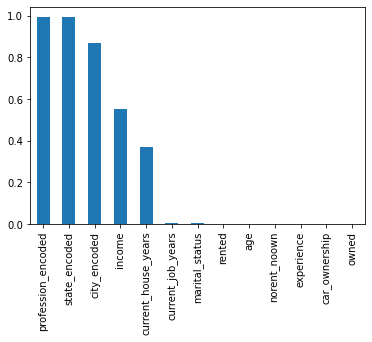

In [10]:
# # https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    use_label_encoder=False,
                    random_state=2021)

variations = ["base", "smote", "chi_square", "pca", "smote, chi_square", "smote, pca"]

for variation in variations:
    run_variation_model(x_train, y_train, x_test, y_test, variation)